In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.spatial import distance

In [2]:

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [3]:
in_dir = "data/"
ct_dicom = dicom.read_file(in_dir + "Training.dcm")
ct_img = ct_dicom.pixel_array
print(ct_img.shape)
print(ct_img.dtype)

(512, 512)
int16


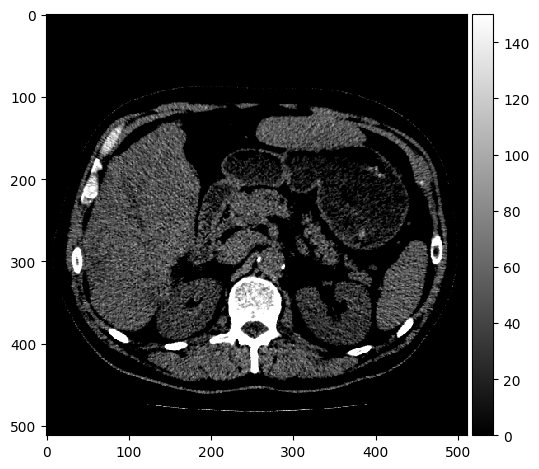

In [4]:
io.imshow(ct_img, vmin=0, vmax=150, cmap='gray')
io.show()

In [5]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = ct_img[spleen_mask]

In [6]:
#get average and std of the spleen pixels
avg = np.mean(spleen_values)
std = np.std(spleen_values)
print(f'The average of the spleen values are {avg:.2f}, and the standard diviation of the the same pixels are {std:.2f}')

The average of the spleen values are 49.48, and the standard diviation of the the same pixels are 15.00


Both numbers seem larger than they should be, according to the diagram in the readme file

(array([ 16.,  30., 105., 284., 578., 615., 388., 150.,  47.,  17.]),
 array([-3. ,  7.2, 17.4, 27.6, 37.8, 48. , 58.2, 68.4, 78.6, 88.8, 99. ]),
 <BarContainer object of 10 artists>)

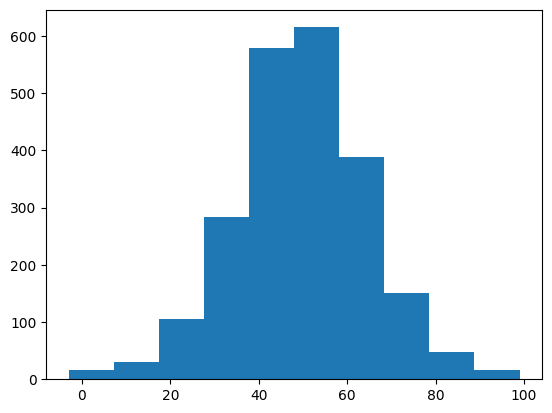

In [7]:
plt.hist(spleen_values)


Ser relativt normalt fordelt ud

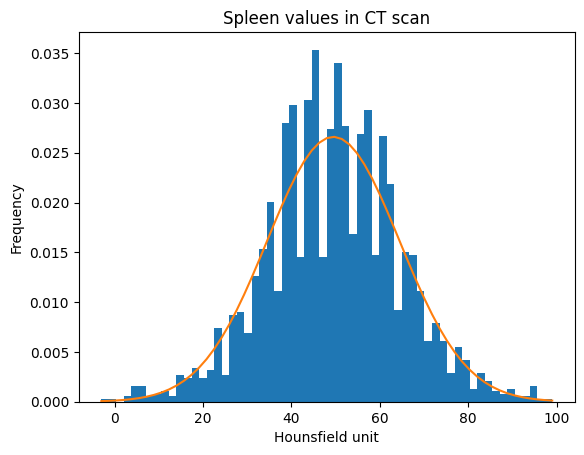

In [8]:
n, bins, patches = plt.hist(spleen_values, 60, density = 1)
pdf_spleen = norm.pdf(bins, avg, std)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

It does look similar to a normal distribution. It does however have some bins in the middle with a lot less occurences, which makes it less likely to be normal

In [9]:
#Making masks for bone, spleen, liver as a function for later use
def get_mask_vals(in_dir, roi):
    temp_roi = io.imread(in_dir + roi)
# convert to boolean image
    temp_mask = temp_roi > 0
    temp_values = ct_img[temp_mask]
    return temp_values


In [10]:
bone_values = get_mask_vals(in_dir, "BoneROI.png")
liver_values = get_mask_vals(in_dir, "LiverRoi.png")
fat_values = get_mask_vals(in_dir, "FatRoi.png")
kidney_values = get_mask_vals(in_dir, "kidneyRoi.png")
mu_bone, std_bone  = np.mean(bone_values), np.std(bone_values)
mu_liver, std_liver  = np.mean(liver_values), np.std(liver_values)
mu_fat, std_fat  = np.mean(fat_values), np.std(fat_values)
mu_kidney, std_kidney  = np.mean(kidney_values), np.std(kidney_values)

Looking at multiple normal distribution for different parts of the images can be good to see how they differ.

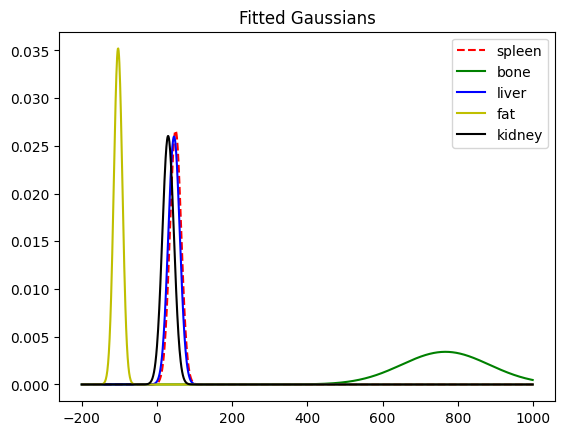

In [11]:
min_hu = -200
max_hu = 1000

hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, avg, std)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_liver, 'b', label="liver")
plt.plot(hu_range, pdf_fat, 'y', label="fat")
plt.plot(hu_range, pdf_kidney, 'black', label="kidney")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Seems like the spleen and the liver will be difficult to those between

In [16]:
#classes classified
classes = ["Fat", "Liver, Spleen, Kidney", "Bone"]
#The middle three are combined as they are very similar

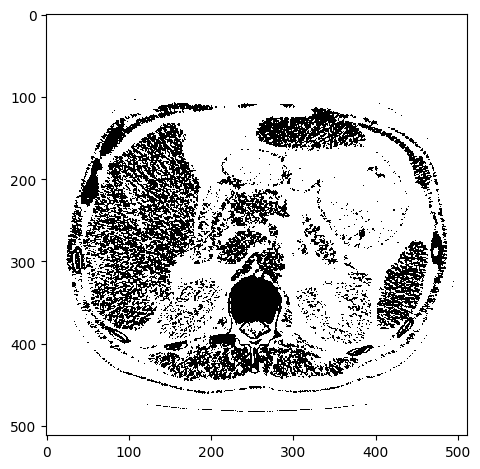

In [17]:
t_background = -200
t_fat_soft = (avg + mu_liver + mu_kidney)/3
t_soft_bone = (t_fat_soft + mu_bone)/2

fat_img = (ct_img > t_background) & (ct_img <= t_fat_soft)
bone_img = (ct_img > t_soft_bone)
soft_img = (ct_img > t_fat_soft) & (ct_img <= t_soft_bone)
io.imshow(np.logical_not(soft_img))
#io.imshow(np.logical_not(bone_img), cmap = "gray")

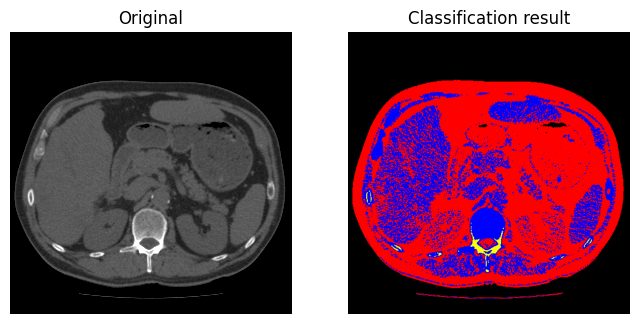

In [67]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(ct_img, image_label_overlay, 'Classification result')

It looks like a fine starting point, but it is off for sure. The bone is not really disstict like it should have been

In [19]:
def get_intersection(class1, class2, x0 = 0):
    vals1 = get_mask_vals(in_dir, class1)
    vals2 = get_mask_vals(in_dir, class2)
    key_nums_vals1 = (np.mean(vals1), np.std(vals1))
    key_nums_vals2 = (np.mean(vals2), np.std(vals2))
    func_pdf1 = lambda x: norm.pdf(x, key_nums_vals1[0], key_nums_vals1[1])
    func_pdf2 = lambda x: norm.pdf(x, key_nums_vals2[0], key_nums_vals2[1])
    intersection = lambda x: func_pdf1(x) - func_pdf2(x)
    x_intersection, = fsolve(intersection, x0)
    return x_intersection

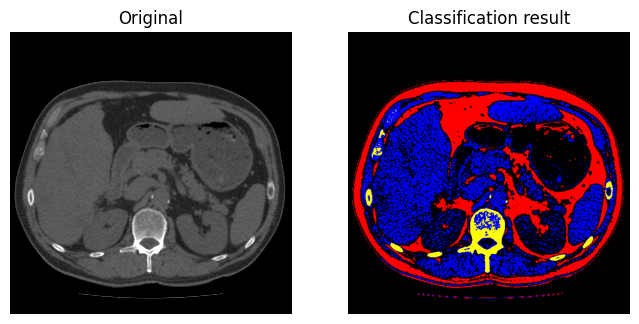

In [20]:
t_fat_soft_int = get_intersection("FatROI.png", "KidneyROI.png", x0 = -10)
t_soft_bone_int = get_intersection("SpleenROI.png", "BoneROI.png", x0 = 100)

In [21]:
fat_img = (ct_img > t_background) & (ct_img <= t_fat_soft_int)
bone_img = (ct_img > t_soft_bone_int)
soft_img = (ct_img > t_fat_soft) & (ct_img <= t_soft_bone_int)
#io.imshow(np.logical_not(soft_img))
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(ct_img, image_label_overlay, 'Classification result')

SyntaxError: invalid syntax (425040848.py, line 1)

Much better! Every part looks a lot more distinct here

### Use probability to create thresholds

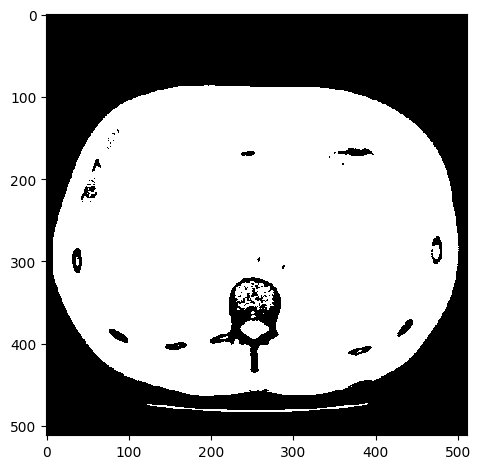

In [25]:
if norm.pdf(test_value, mu_soft, std_soft) > norm.pdf(test_value, mu_bone, std_bone):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is bone")

In [23]:
#To be used like this:
bone_img_prob = (norm.pdf(ct_img, avg, std) < norm.pdf(ct_img, mu_bone, std_bone)) & (norm.pdf(ct_img, mu_fat, std_fat) < norm.pdf(ct_img, mu_bone, std_bone))
io.imshow(np.logical_not(bone_img_prob))

SyntaxError: invalid syntax (3384184015.py, line 1)

Man kunne her lave et lookup table i stedet. Give hver pixel en klasse, og et pixel nummer, så sortere det så man kan finde ud af hvornår det skifter fra den ene til den anden. hvis man vil have et specifikt threshold

# Object segmentation

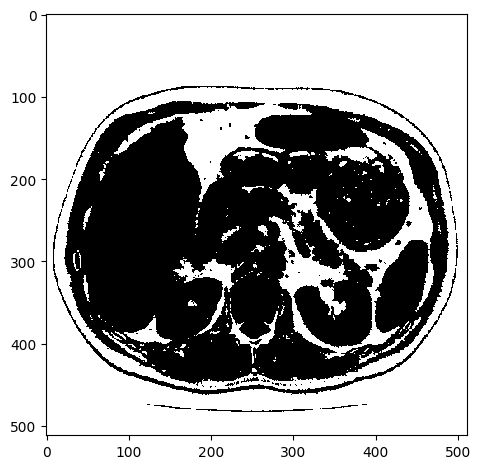

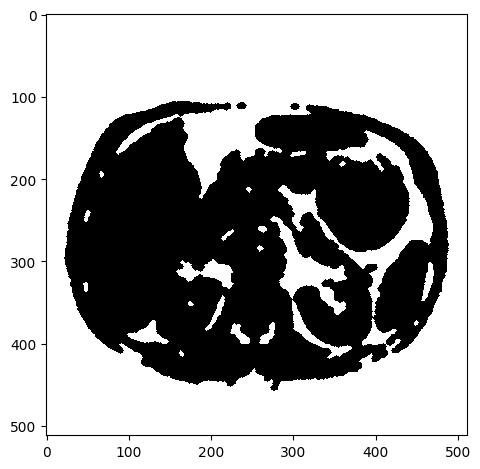

In [49]:
#I've chosen to use intersection to make the thresholds
spleen_estimate = (ct_img > t_fat_soft_int) & (ct_img < t_soft_bone)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()